# Sentiment Analysis

## Importar Librerías

In [ ]:
#!pip install emoji
#!pip install uralicNLP
#!pip install hfst
#!pip install hfst-dev
#!pip install sentiment-analysis-spanish
#!pip install transformers
#!pip install wordcloud

In [ ]:
import pandas as pd
import numpy as np
import numpy as np
import seaborn as sns
import emoji
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sentiment_analysis_spanish import sentiment_analysis

from transformers import pipeline

import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [ ]:
#nltk.download('all')
#uralicApi.download("spa")

## Limpieza de Datos

In [ ]:
df = pd.read_csv("db.csv")
df.shape

In [ ]:
df.head(10)

In [ ]:
df.info()

In [ ]:
df["car"] = [len(msg) for msg in df["tweet"]]
df["pal"] = [len(msg.split()) for msg in df["tweet"]]

In [ ]:
df.head(10)

### Algunas Gráficas Iniciales

In [ ]:
# Equivalente a:
sns.histplot(x = "car", data = df).set(xlabel='Cantidad de Caracteres', ylabel='Conteo')

In [ ]:
# Equivalente a:
sns.histplot(x = "pal", data = df).set(xlabel='Cantidad de Palabras', ylabel='Conteo')

In [ ]:
df.sort_values(by = 'pal', ascending = True).head(20)

In [ ]:
df.sort_values(by = 'pal', ascending = False).head(20)

### Desemojizar

In [ ]:
for i in range(len(df)):
    df.loc[i,'tweet'] = emoji.demojize(df.loc[i,'tweet'], language='es')

In [ ]:
df

## Sentiment Analysis

### Preprocesar Texto

In [ ]:
# Función para preprocesar el texto
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('spanish')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    
    
    # ----------- LIMPIAR CARACTERES Y PALABRAS ----------------
    processed_text = processed_text.replace(',', '')
    processed_text = processed_text.replace('.', '')
    processed_text = processed_text.replace(':', '')
    processed_text = processed_text.replace(',', '')
    processed_text = processed_text.replace('!', '')
    processed_text = processed_text.replace('¡', '')
    #processed_text = processed_text.replace('gracias', '')
    #processed_text = processed_text.replace('muchas', '')
    
    #processed_text = processed_text.replace('_', ' ')
    #processed_text = processed_text.replace('cara', '')
    

    return processed_text

In [ ]:
df['reviewText'] = df['tweet'].apply(preprocess_text)
# Eliminar las filas con texto vacío
df = df.loc[df['reviewText'] != '', :]
df

### NLTK Sentiment Analysis

In [ ]:
# initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create get_sentiment function
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

# apply get_sentiment function
df['sentNLTK'] = df['reviewText'].apply(get_sentiment)

### SentimentAnalysisSpanish

In [ ]:
sentiment = sentiment_analysis.SentimentAnalysisSpanish()
#print(sentiment.sentiment("me gusta la tombola es genial"))

df['sentSpnsh'] = df['reviewText'].apply(sentiment.sentiment)

In [ ]:
#wnl = WordNetLemmatizer()
#print(wnl.lemmatize('resting'))

In [ ]:
#from uralicNLP import uralicApi
#print(uralicApi.lemmatize("poder","spa"))

In [ ]:
#df[['reviewText', 'sentiment']].head(25)

### Sentiment Analysis Transformers

In [ ]:
classifier = pipeline('sentiment-analysis', 
                      model="nlptown/bert-base-multilingual-uncased-sentiment")

results = classifier(list(df['reviewText']))

#for i in range(len(results)):
#    print(df.loc[i, 'reviewText'])
#    print(f"polaridad: {results[i]['label']}, score: {round(results[i]['score'], 4)}")
    
results = [int(result['label'].split()[0]) for result in results]
df['sentTransf'] = results
df

In [ ]:
"""
classifier = pipeline('sentiment-analysis', 
                      model="nlptown/bert-base-multilingual-uncased-sentiment")

sentences = ["HeyBanco me hace muy feliz, es lo mejor",
            "Odio a todos, en especial a HeyBanco, es una basura",
            "Hoy tuve un problema con mi tarjeta de crédito, pero ya lo solucioné"]

results = classifier(sentences)
for result in results:
    print(f"polaridad: {result['label']}, score: {round(result['score'], 4)}")
    print(int(result['label'].split()[0]))

results = [int(result['label'].split()[0]) for result in results]
print(results)
"""

In [ ]:
df.to_csv('contrasteSentimientos.csv', index=False)

Decidimos conservar el tercer análisis de sentimientos, pues resulta ser el más acertado, aunque la escala discreta no es tanto de nuestro agrado.

## Gráfica de Violín sobre Sentimientos en el Tiempo

In [ ]:
#db['date'] = db['date']

#df['date'] = [pd.to_datetime(fecha, format='%Y-%m-%d') for fecha in df['date']]
#pd.to_datetime('2023-01-01', format='%Y-%m-%d')

In [ ]:
df = pd.read_csv("contrasteSentimientos.csv")
df['Sentimiento'] = df['sentTransf']
df = df[['date', 'time', 'tweet', 'pal', 'reviewText', 'Sentimiento']]

In [ ]:
for i in range(len(df['date'])):
    if pd.isna(df.loc[i, 'time']) or True: # Quitar el True para cambiar formato según si está disponible la hora
        df.loc[i, 'date'] = pd.to_datetime(df.loc[i, 'date'], format='%Y-%m-%d')
    else:
        df.loc[i, 'date'] = pd.to_datetime(df.loc[i, 'date'] + ' ' + df.loc[i, 'time'], format='%Y-%m-%d %H:%M:%S')

df.drop('time', axis = 1, inplace = True)
df

In [ ]:
df.info()

In [ ]:
for i in range(len(df['Sentimiento'])):
    if df.loc[i, 'Sentimiento'] > 3:
        df.loc[i, 'Positivo'] = 1
        df.loc[i, 'Negativo'] = 0
    else:
        df.loc[i, 'Positivo'] = 0
        df.loc[i, 'Negativo'] = 1


df2 = df[['date', 'Positivo', 'Negativo']].groupby(['date']).sum()

In [ ]:
df2.to_csv('sentimientosPorFecha.csv', index=True)

In [ ]:
df2 = pd.read_csv('sentimientosPorFecha.csv')
df2

In [ ]:
df2['date'] = pd.to_datetime(df2['date'])
df2['month'] = df2['date'].dt.month
df2['year'] = df2['date'].dt.year

def f_mes(n_mes,año):
    df_año = df2[df2['year']==año]
    df_mes = df_año[df_año['month']==n_mes]
    return df_mes
def grafico_comentarios(mes,año):
    fig, ax = plt.subplots()
    ax.bar(f_mes(mes,año).date, f_mes(mes,año).Positivo)
    ax.bar(f_mes(mes,año).date, f_mes(mes,año).Negativo*-1)

    if mes == 1:
        m = 'Enero'
    if mes == 2:
        m = 'Febrero'
    if mes == 3:
        m = 'Marzo'
    if mes == 4:
        m = 'Abril'
    if mes == 5:
        m = 'Mayo'
    if mes == 6:
        m = 'Junio'
    if mes == 7:
        m = 'Julio'
    if mes == 8:
        m = 'Agosto'
    if mes == 9:
        m = 'Septiembre'
    if mes == 10:
        m = 'Octubre'
    if mes == 11:
        m = 'Noviembre'
    if mes == 12:
        m = 'Diciembre'

    # Formatting x labels
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.tick_params(labelbottom=False)
    plt.tight_layout()
    plt.title('Comentarios positivos vs negativos')
    plt.xlabel('Dias de '+m+' '+str(año))
    #plt.ylabel('Dias')
    
    # Use absolute value for y-ticks
    ticks =  ax.get_yticks()
    ax.set_yticklabels([int(abs(tick)) for tick in ticks])
    
    plt.show()

grafico_comentarios(3,2023)

## Clasificación de Relevancia

In [ ]:
# Equivalente a:
sns.scatterplot(x = "Sentimiento", y = "pal", data = df).set(xlabel='Sentimiento', ylabel='Cantidad de Palabras')

## Nube de Palabras

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in df['reviewText']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud para Todos los Tweets', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in df.loc[df['Positivo'] == 1, 'reviewText']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=20)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud para Tweets Positivos', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
# Combine all reviews
reviews = " ".join([review for review in df.loc[df['Sentimiento'] == 1, 'reviewText']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=20)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud para Tweets Negativos', fontsize=10)
plt.axis('off')
plt.show()

## Modelo para Predecir Sentimientos

In [ ]:
dfSVM = df[['tweet', 'Positivo']]

In [ ]:
dfSVM

### Tokenize

In [ ]:
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('spanish'))

In [ ]:
import re
import pickle

In [ ]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, dfSVM.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', dfSVM.iloc[i]['tweet'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = dfSVM['Positivo'].values

In [ ]:
#Saving the Count Vectorizer
#pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [ ]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

In [ ]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

In [ ]:
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

#### Grid Search

In [ ]:
params = {
    'bootstrap': [True, False],
    'max_depth': [80, 100, 50],
    'min_samples_split': [8, 12, 50, 25, 4],
    'n_estimators': [100, 300, 50]
}

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

In [ ]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

In [ ]:
from sklearn.metrics import accuracy_score
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

### Support Vector Machine

In [479]:
from sklearn.svm import SVC
#Fitting scaled X_train and y_train on Random Forest Classifier
model_svc = SVC(C=1,kernel='linear')
model_svc.fit(X_train_scl, y_train)

SVC(C=1, kernel='linear')

In [480]:
print("Training Accuracy :", model_svc.score(X_train_scl, y_train))
print("Testing Accuracy :", model_svc.score(X_test_scl, y_test))

Training Accuracy : 0.982363315696649
Testing Accuracy : 0.7172131147540983


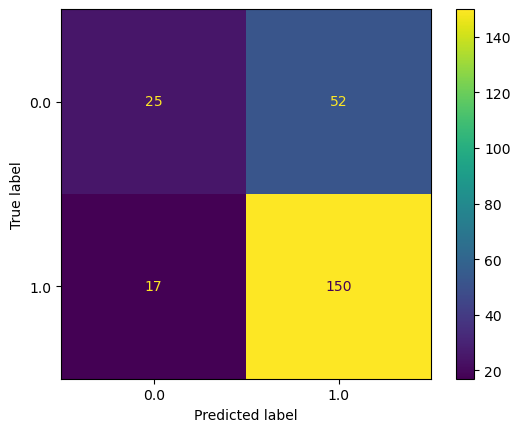

In [481]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Predicting on the test set
y_preds = model_svc.predict(X_test_scl)
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_svc.classes_)
cm_display.plot()
plt.show()

In [482]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = model_svc, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.7550438596491228
Standard Variance : 0.04233253766329353


In [402]:
params = {
    'kernel': ['linear','poly','rbf'],
    'C': [1,1.25,1.5,2,2.5,3,4,5]
}

In [476]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_svc, param_grid = params, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(estimator=SVC(C=3),
             param_grid={'C': [1, 1.25, 1.5, 2, 2.5, 3, 4, 5],
                         'kernel': ['linear', 'poly', 'rbf']},
             return_train_score=True)

In [478]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'C': 1, 'kernel': 'linear'}


In [407]:
from sklearn.metrics import accuracy_score
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 95.69374802999387
Cross validation mean accuracy on test set : 72.16425392757012
Accuracy score for test set : 0.6926229508196722
